### Payload downlink calculations

Calculations are based on the Marana camera as the CCD detector

In [5]:
### Marana ###
total_px = 2048 * 2048
bits_per_frame = 16
bytes_per_frame = bits_per_frame/8

### Image size ###
img_size = total_px * bytes_per_frame
print(f'Image size = {img_size/(10**6)} MB')

### Exposure time ###
exp_time = 100 

### Orbit Period ###
period = 5400 # 90 mins = 5400 seconds

### Number of Images per orbit ###
img_num = ((period/2) - 100)/ exp_time
print(f'The total number of images per orbit are {img_num}')

### Number of orbits ### 
number_of_orbits = (24 * 60) / 90 # (24hours x 60 minutes) / 90 minutes 
print(f'The total number of orbits per day are {number_of_orbits}')

### Amount of payload data to be sent to ground station per day ###
img_data = number_of_orbits * img_num * img_size

print(f'Payload data = {img_data/(10**9)} GB/day')

Image size = 8.388608 MB
The total number of images per orbit are 26.0
The total number of orbits per day are 16.0
Payload data = 3.489660928 GB/day


## The channel capacity

#### Nyquist Bandwidth Theorem
$$
C = 2B\log_2(M)
$$

M - signal levels/ Baud rate?

C - Channel capacity in bits per seconds

#### Shanon Capacity Theorem
$$
C = B\log_2(1 + SNR)
$$

SNR - Signal to noise ratio - unitless 

$$
Bandwidth = 2 f_c
$$

In [4]:
import math 

def db_conversion(snr):
    '''
    ----------------------------------
    Converts the SNR from decibels 
    to unitless quantity
    '''
    return 10 ** (snr/10)

def bytes_to_bits(bytes_):
    '''
    1 byte = 8 bits
    -------------------------------------
    returns conversion from bytes to bits
    '''
    return bytes_ * 8 

def shanon(capacity,snr_db):
    '''
    input parameters
    ------------------------------------------
    channel capacity in Giga Bytes (GB) = 3 GB
    
    SNR in decibels = 5 dB
    --------------------------------
    returns channel bandwidth in MHz
    '''
    snr = db_conversion(snr_db)
    capacity = capacity * (10**9)
    c = bytes_to_bits(capacity)
    bw = (c/ (math.log2(1+snr)))/(10**6)
    return round(bw,4)

def nyquist(capacity, bw):
    '''
    input parameters
    -----------------------------------
    capacity in Giga Bytes (GB) = 3 GB
    
    bandwidth in MHz
    -----------------------------------
    returns number of symbols
    '''
    capacity = capacity * (10**9)
    c = bytes_to_bits(capacity)
    ### The bandwidth needs to be converted to from MHz to Hz ###
    bw = bw * (10**6)
    exp = c/(2*bw)
    return math.ceil(2**exp)

CHANNEL_CAPACITY = 0.014 #(img_data)/(10**9) # GHz

### Computing the bandwidth for a given channel capacity and SNR ###
bandwidth = shanon(CHANNEL_CAPACITY, 10)
print(f'The channel bandwidth is {bandwidth} MHz')
print(' ')

### Frequency downlink ###
freq_dl = bandwidth/2
print(f'The downlink frequency is {freq_dl} MHz')
print(' ')

### Computing the number of symbols for transmission ###
###### Helps to decide the type of modulation (BPSK,QPSK) #######
symbols = nyquist(CHANNEL_CAPACITY, bandwidth)
print(f'The number of symbols required are {symbols}')
print(' ')

The channel bandwidth is 32.3753 MHz
 
The downlink frequency is 16.18765 MHz
 
The number of symbols required are 4
 


#### Antenna Selection Criteria

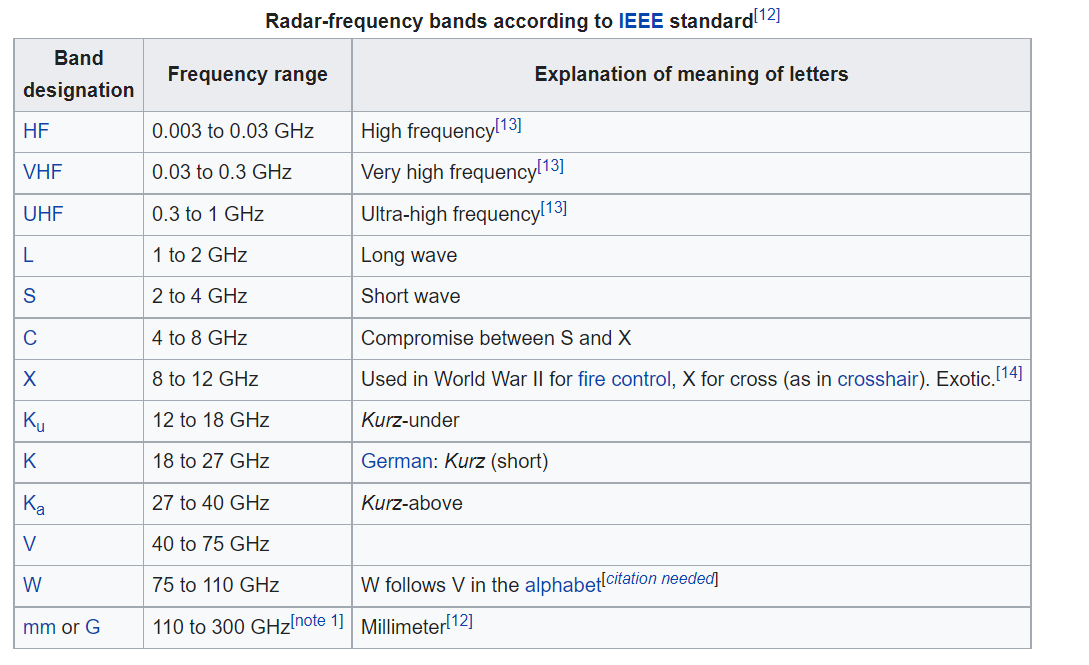

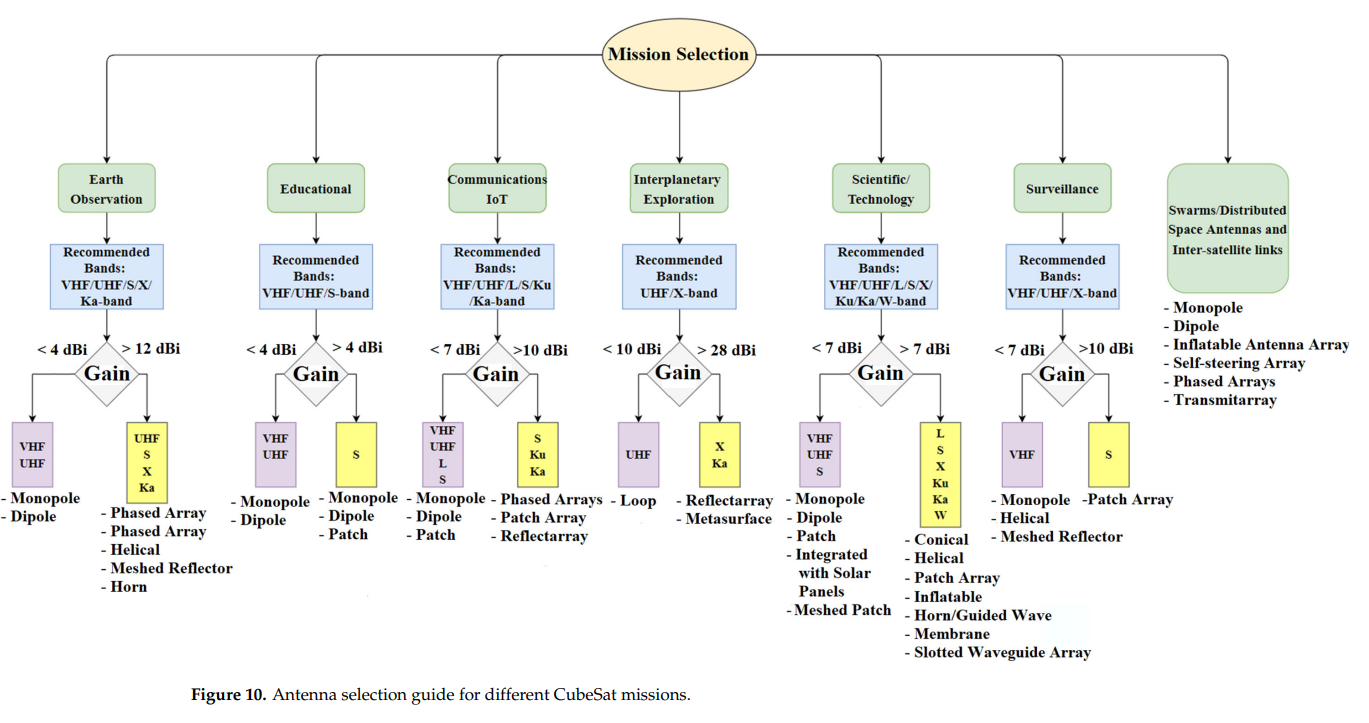

#### Cubesat Antenna Manufacturers

https://www.cubesatshop.com/product-category/antenna-systems/ 

https://gomspace.com/shop/subsystems/communication-systems/default.aspx

https://www.isispace.nl/product/s-band-patch-antenna/

https://nanoavionics.com/cubesat-components/cubesat-s-band-patch-antenna/


#### Image Compression

$$
Noise Bits = log_2(sigma) + 1.792
$$

$$
Compression \hspace{0.3cm} ratio =  \dfrac{BITPIX} {Nbits +K}
$$

BITPIX = Number of bits in each pixel value

K = 1.2 (Rice Algorithm)

K = 0.9 (Hcompress)

k = 4 or 5 (GZIP)

In [13]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bitpixel = 16 # For Marana camera

### Noise Bits Calculations ###
sigmas = np.arange(0.5,11,0.5)
nbits = [round(math.log2(sigma) + 1.792,5) for sigma in sigmas]

### Compression Ratio for Rice algorithm ###
cr_rice = [ round(bitpixel/(nbit + 1.2), 4) for nbit in nbits]

### Compression Ratio for Hcompress algorithm ###
cr_hcompress = [ round(bitpixel/(nbit + 0.9), 4) for nbit in nbits]

### Compression Ratio for GZIP algorithm ###
cr_gzip = [ round(bitpixel/(nbit + 4.5), 4) for nbit in nbits]

### Tabulate the data ###
table = {'Sigma':sigmas, 'Noise Bits':nbits, 
         'Compression Ratio (Rice)':cr_rice, 
         'Compression Ratio (Hcompress)' :cr_hcompress, 
         'Compression Ratio (GZIP)' :cr_gzip}
compression_ratio = pd.DataFrame(table)
compression_ratio

,Sigma,Noise Bits,Compression Ratio (Rice),Compression Ratio (Hcompress),Compression Ratio (GZIP)
0,0.5,0.79200,8.0321,9.4563,3.0234
1,1.0,1.79200,5.3476,5.9435,2.5429
2,1.5,2.37696,4.4731,4.8826,2.3266
3,2.0,2.79200,4.0080,4.3337,2.1942
4,2.5,3.11393,3.7089,3.9861,2.1014
5,3.0,3.37696,3.4958,3.7410,2.0312
6,3.5,3.59935,3.3338,3.5561,1.9755
7,4.0,3.79200,3.2051,3.4101,1.9296
8,4.5,3.96193,3.0996,3.2909,1.8908
9,5.0,4.11393,3.0110,3.1911,1.8575


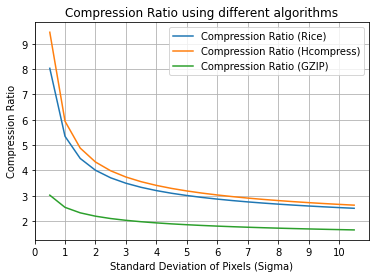

In [15]:
compression_ratio.plot(x='Sigma', 
                       y=['Compression Ratio (Rice)', 'Compression Ratio (Hcompress)', 'Compression Ratio (GZIP)'], 
                       title = 'Compression Ratio using different algorithms', 
                       ylabel = 'Compression Ratio', 
                       xlabel = 'Standard Deviation of Pixels (Sigma)', 
                       grid = True, 
                       xticks = np.arange(0,11))
plt.savefig(r'D:\Gavin\Academics\UCD\Internship\UV_Cubesat_data\compression.pdf')

### Contact time with ground station